In [1]:
import random
import torch
import pandas as pd
from matplotlib import pyplot as plt
from torchvision import transforms

import data_utils
import utils

## Settings

In [2]:
dataset_name = "imagenet_val"#"imagenet_val"#"cifar100_val"#places365_val
target_name = "resnet50_imagenet"#vit_b_16_imagenet#"vit_l_32_imagenet"#"resnet50_imagenet"#"vgg16_bn_cifar100"
target_layer = "layer4"#layer4#"encoder.layers.encoder_layer_23.mlp[1]"#"classifier[4]"
target_neuron = 136#random.randint(0, 2048)
batch_size = 256
save_dir = 'saved_activations'
device = "cuda"
pool_mode = "avg"#"avg"#"first"

model, preprocess = data_utils.get_target_model(target_name, device=device)

## Run required results

In [3]:
#setup transforms
try:
    pre_mean = torch.FloatTensor(preprocess.mean)
    pre_std = torch.FloatTensor(preprocess.std)
except(AttributeError):
    pre_mean = torch.FloatTensor(preprocess.transforms[-1].mean)
    pre_std = torch.FloatTensor(preprocess.transforms[-1].std)
anti_preprocess = transforms.Normalize(-1*pre_mean/pre_std, 1/pre_std)

to_image = transforms.ToPILImage()

In [4]:
dataset = data_utils.get_data(dataset_name, preprocess)
pil_data = data_utils.get_data(dataset_name)

In [5]:
#special case for 1d activations
if target_layer == 'classifier[4]':
    activations = None
    save_path = '{}/{}_{}/{}/'.format(save_dir, target_name, dataset_name, target_layer)
    print(save_path)
    summary_activations = utils.save_summary_activations(model, dataset, device, target_layer, batch_size, save_path, pool_mode="avg")
    summary_activations = summary_activations[:, target_neuron]

elif pool_mode == 'first':
    activations = None
    save_path = '{}/{}_{}/{}/'.format(save_dir, target_name, dataset_name, target_layer)
    print(save_path)
    summary_activations = utils.save_summary_activations(model, dataset, device, target_layer, batch_size, save_path, pool_mode="first")
    summary_activations = summary_activations[:, target_neuron]

elif pool_mode == 'avg':
    neuron_save_path = '{}/{}_{}/{}/{}'.format(save_dir, target_name, dataset_name, target_layer, target_neuron)
    activations = utils.save_activations(model, dataset, device, target_layer, target_neuron, batch_size, neuron_save_path)
    #reshape ViT activations
    print(activations.shape)
    if len(activations.shape) == 2:
        n, s = activations.shape
        #calculate input size
        d = int((s-1)**0.5)
        activations = activations[:, 1:].reshape(n, d, d)
        summary_activations = activations.mean(dim=[1,2]).cpu()
    elif len(activations.shape) == 1:
        summary_activations = activations
        activations = None
    else:
        summary_activations = activations.mean(dim=[1,2]).cpu()

100%|██████████| 196/196 [01:27<00:00,  2.24it/s]

torch.Size([50000, 7, 7])


## Load results from existing methods

In [6]:
def linear_to_str(df, target_neuron):
    df = df[df["unit"]==target_neuron]
    
    desc = "{:.2f}∙{}".format(df["weight0"].iloc[0], df["concept0"].iloc[0])
    
    for k in range(1, 10):
        concept = df["concept{}".format(k)].iloc[0]
        if str(concept) != "0":
            desc += " + {:.2f}∙{}".format(df["weight{}".format(k)].iloc[0], concept)
    desc += " + {:.2f}".format(df["bias"].iloc[0])
    return desc

explanations = {"net_dissect":None, "milan":None, "clip_dissect":None, "le_label":None, "le_siglip":None} 

for method in explanations:
    try:
        explanation_path = utils.EXPLANATION_PATHS[method] + "{}_{}.csv".format(target_name, target_layer)
        df = pd.read_csv(explanation_path)
        if method.startswith("le_"):
            explanations[method] = linear_to_str(df, target_neuron)
        else:
            explanations[method] = df[df["unit"]==target_neuron]["description"].iloc[0]
    except(FileNotFoundError):
        explanations[method] = "N/A"
    

## Visualize neuron

In [7]:
def plot_images(images, axs):
    """
    images: list
    """
    
    for i, top_id in enumerate(images):
        #normalize to 0-1 range
        if activations != None:
            curr_act = activations[top_id]
            curr_act -= curr_act.min()
            curr_act /= curr_act.max()
            mask = curr_act.unsqueeze(0)
        else:
            mask = torch.ones((1, 1, 1))
                    
        x, label = dataset[top_id]
        x = anti_preprocess(x)
        mask_resize = transforms.Resize((x.shape[1], x.shape[2]), antialias=True)
        mask = mask_resize(mask).cpu()
        x = x * mask
        im = to_image(x)
        axs[i].imshow(im)
        axs[i].axis('off')

In [8]:
nice_names = {"net_dissect": "Network Dissection",
              "milan": "MILAN",
              "clip_dissect": "CLIP-Dissect",
              "le_label": "LE(Label)",
              "le_siglip": "LE(SigLIP)"}

Neuron 136 - Descriptions and highly activating images 

Network Dissection: mountain snowy
MILAN: People, animals
CLIP-Dissect: skiing
LE(Label): 2.78∙snowmobile + 2.60∙ski + 1.97∙sled + 1.80∙balaclava ski mask + 0.36∙hound + 0.25∙canine + 0.32
LE(SigLIP): 4.24∙ski + 2.94∙dogsled + 2.57∙snow + 1.53∙Afghan Hound + 1.35∙sporting dog + 0.28


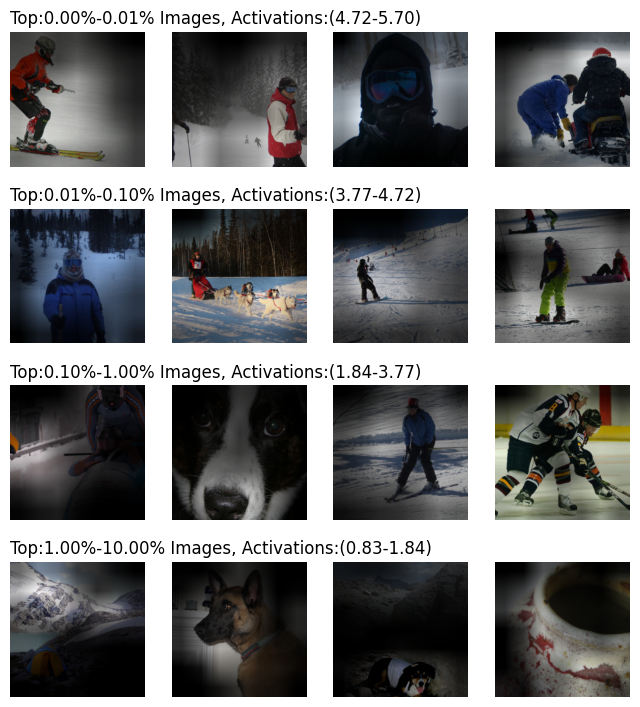

In [9]:
sorted_act_vals, sorted_act_ids = torch.sort(summary_activations, descending=True)

print("Neuron {} - Descriptions and highly activating images \n".format(int(target_neuron)))

for i, method in enumerate(explanations):
    print("{}: {}".format(nice_names[method], explanations[method]))

#nums = [0, 5, 20, 50, 200, 500, 2000, 5000, 10000, 20000]
nums = [0, 5, 50, 500, 5000]

n_images = 4
fig, ax = plt.subplots(nrows = len(nums[1:]), ncols=n_images, figsize=(2*n_images, 2.2*len(nums[1:])))

for i, num in enumerate(nums[1:]):
    prev_num = nums[i]
    ax[i, 0].set_title("Top:{:.2f}%-{:.2f}% Images, Activations:({:.2f}-{:.2f})".format(prev_num/len(summary_activations)*100,
                                                                                        num/len(sorted_act_ids)*100,
                                                                                        sorted_act_vals[num], sorted_act_vals[prev_num]),
                                                                                        loc="left")
    perm = torch.randperm(num-prev_num)
    to_show = sorted_act_ids[prev_num:][perm[:n_images]]
    plot_images(to_show, axs=ax[i])

#plt.tight_layout()
plt.show()